In [1]:
col_names = [
    'dv-fv',
    'dv', 
    'fv'
]

In [172]:
import configparser
import warnings
import pandas as pd
from pymongo import MongoClient
import json
import requests
from bs4 import BeautifulSoup

warnings.filterwarnings("ignore", category=DeprecationWarning)

config = configparser.ConfigParser()
config.read('config.ini')
host = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']
user = config['DEFAULT']['User']
pw = config['DEFAULT']['Pw']

client = MongoClient(host, int(port), username=user, password=pw)
db = client['mediacloud']

# Copy to Local

In [174]:
df = pd.DataFrame()
for col in col_names:
    df = pd.concat([df, pd.DataFrame(list(db[col].find()))])
df.shape

(12845, 17)

In [175]:
df_test = df.copy()
titles = []
texts = []

for _,row in df_test.iterrows():
    title = row['title'].replace('&#8217;', "'").replace('&#8216;',"'").replace('&#8230;','...').replace('&#8211;','-').replace('&#124;','|').replace('&#39;',"'").replace('&#038;','&').replace('&#8220;','"').replace('&#8221;','"')
    text = row['text'].replace('&#x2019;', "'").replace('&#275;','e')
    titles.append(title)
    texts.append(text)
    
df_test['title'] = titles
df_test['text'] = texts

In [181]:
df = df_test.copy()
df.to_csv('database/media_cloud_database.csv')

# Topic Modelling

In [88]:
import numpy as np

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

# NLTK
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer 

In [18]:
lmtz = WordNetLemmatizer()


def lemmatize(word):
    if word.startswith('#'):
        return word
    
    lemma = lmtz.lemmatize(word, 'v')
    if lemma == word:
        lemma = lmtz.lemmatize(word, 'n')
    return lemma


def strip_punc(s):
    return ''.join([c for c in s if c.isalpha()])

In [196]:
stop_words = [strip_punc(w) for w in stopwords.words('english')]
stop_words.extend([
    'i',
    'u',
    'r',
    'im',
    'cant',
    'would',
    'family',
    'domestic',
    'violence',
    'australia',
    'australian',
    'dv',
    'fv',
    'via',
    'today',
    'thing',
    'make',
    'talk',
    'due',
    'day',
    'month',
    'find',
    'show',
    'put',
    'part',
    'time',
    'yeah',
    'deal',
    'big',
    'level',
    'focus',
    'theyre',
    'list',
    'top',
    'give',
    'situation',
    'lot',
    'hold',
    'number',
    'include',
    'form',
    'back',
    'involve',
    'link',
    'real',
    'good',
    'get',
    'go',
    'have',
    'do',
    'take',
    'time','year','month','week','day','say',
    'per','cent','percent','people'
])

### Parameters

In [337]:
year = 2018
start = 7
limit = 16
step = 1
n = 20 #how many articles to extract for each topic

### Main

In [338]:
df_current = df[df['publish_date'].str.contains(str(year))]
df_current.reset_index(inplace=True)
len(df_current)

6038

In [339]:
data = []

for i, row in df_current.iterrows():
#     text = str(row['text']).replace('.','|').replace('?','|').replace('!','|')
#     splits = text.split('|')
#     x = np.min([10, len(splits)])
#     data.append(' '.join(splits[:x]))
    data.append(row['text'])
        
    if i % 100 == 0:
        print(i, end = ' ')

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 

### Pre-processing

In [340]:
data_lemmatized = []
data_filtered = []

for i, sent in enumerate(data):
    
    cleaned_sent = ''
    for token in sent.split():
        
        # Cleaning
        if token[0] in ['@','$','%','^','&','*','#'] or token.startswith('http'):
            continue

        # Remove puctuations, lower case
        token = strip_punc(token.lower())
        
        # Lemmatize
        lemma = lemmatize(token)

        if lemma and lemma not in stop_words:
            cleaned_sent += lemma + ' '
    
    cleaned_sent = cleaned_sent.strip()
    
    data_lemmatized.append(cleaned_sent.split())
    data_filtered.append(sent)
        
    if i % 100 == 0:
        print(i, end=' ')
        
len(data_lemmatized)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 

6038

In [341]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Model

In [27]:
mallet_path = 'input/mallet-2.0.8/bin/mallet'

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        print(str(len(model_list)-1)+'-'+str(num_topics),end=' ')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [342]:
# Takes a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

0-7 1-8 2-9 3-10 4-11 5-12 6-13 7-14 8-15 

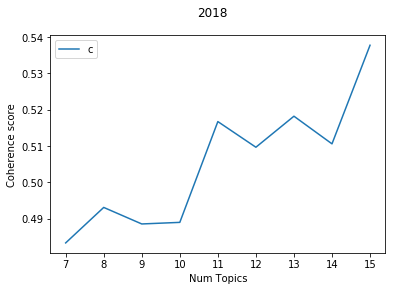

In [343]:
x = range(start, limit, step)
plt.figure().suptitle(str(year))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('output/topic_models/graph_{}_whole.png'.format(year))
plt.show()

In [344]:
no_topics = 15
model = model_list[no_topics-start]
model.save('output/topic_models/{}_{}_whole'.format(year, no_topics))

In [345]:
pyLDAvis.enable_notebook()
the_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_list[no_topics-start])
vis = pyLDAvis.gensim.prepare(the_model, corpus, id2word)
pyLDAvis.save_html(vis, 'output/topic_articles/{}_{}_whole.html'.format(year, no_topics))
#vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Docs

In [346]:
# Finding the dominant topic in each Tweet


def format_topics_sentences(ldamodel, corpus=corpus, texts=data_filtered):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [347]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=data_filtered)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [348]:
# Group top n Tweets under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(n)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# # Format
# sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,4564,0.0,0.6968,"world, work, story, book, write, life, award, play, university, film",We asked a shelf-load of Australian writers to tell us about the books they loved this year. Mea...
1,1870,0.0,0.5923,"world, work, story, book, write, life, award, play, university, film","A teaser glimpse the of hotly-awaited Foxtel reboot of Aussie classic Picnic at Hanging Rock, ou..."
2,4710,0.0,0.5885,"world, work, story, book, write, life, award, play, university, film","Since the early 1980s, every attempt at establishing a fully professional, permanent theatre com..."
3,4763,0.0,0.5741,"world, work, story, book, write, life, award, play, university, film","By the numbers alone, this is a wonderful achievement: the biggest box set ever devoted to a com..."
4,937,0.0,0.5695,"world, work, story, book, write, life, award, play, university, film","As the Weinstein scandal and the #MeToo movement continue to shake Hollywood, the 75th annual Go..."


In [349]:
df_out = sent_topics_sorteddf_mallet.copy()
df_out.drop(['Text'], axis=1, inplace=True)
urls = list(map(lambda x: df_current.iloc[x]['url'], df_out['Document_No']))
titles = list(map(lambda x: df_current.iloc[x]['title'], df_out['Document_No']))
df_out['Title'] = titles
df_out['URL'] = urls

In [292]:
#df_out.to_csv('output/topic_articles/{}_{}_clusters.csv'.format(year, no_topics))

# Excel

In [350]:
# Number of Documents for Each Topic
series_topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

idx = []
topic_counts = []
keywords = []
topic_contributions = []

for (i, count) in series_topic_counts.iteritems():
    idx.append(int(i))
    keywords.append(", ".join([word for word, _ in model.show_topic(int(i))]))
    topic_counts.append(count)
    topic_contributions.append(str(round(100*count/series_topic_counts.sum(), 2))+'%')
    
df_dominant_topics = pd.DataFrame.from_dict({
    'Dominant_Topic_Num': idx,
    'Topic_Keywords': keywords, 
    'Num_Documents': topic_counts, 
    'Perc_Documents': topic_contributions
})

# Show
pd.options.display.max_colwidth = 100
df_dominant_topics.set_index('Dominant_Topic_Num', inplace=True)
df_dominant_topics

,Topic_Keywords,Num_Documents,Perc_Documents
Dominant_Topic_Num,,,
14,"court, man, charge, police, order, assault, magistrate, sentence, hear, victim",726,12.02%
9,"community, local, school, event, online, support, term, discussion, note, comment",670,11.1%
0,"world, work, story, book, write, life, award, play, university, film",634,10.5%
8,"police, crime, officer, incident, report, cent, assault, area, local, increase",471,7.8%
12,"child, government, law, victim, system, report, case, legal, record, state",411,6.81%
3,"government, state, minister, party, labor, million, public, change, mp, national",407,6.74%
2,"murder, police, death, home, kill, child, mother, yearold, die, father",366,6.06%
4,"leave, pay, money, people, work, financial, provide, business, cent, christmas",363,6.01%
7,"woman, men, abuse, sexual, partner, experience, behaviour, victim, relationship, change",363,6.01%


In [351]:
from pandas import ExcelWriter

writer = ExcelWriter('output/topic_articles/{}_{}_clusters_whole_doc.xlsx'.format(year, no_topics))
new_df = df_dominant_topics.copy()
new_df.index += 1
new_df.to_excel(writer,'topic_rank')

for topic_no in range(no_topics):
    new_df = sent_topics_sorteddf_mallet.iloc[topic_no*n:((topic_no+1)*n),[0,4]]
    new_df.set_index('Document_No', inplace=True)
    
    new_df['Title'] = list(map(lambda x: df_current.iloc[x]['title'], new_df.index))
    
    new_df.reset_index(inplace=True)
    new_df.drop(['Document_No'], axis=1, inplace=True)
    new_df.to_excel(writer,'topic_'+str(topic_no+1))
    
writer.save()